In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error,r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

In [2]:
usdInr = pd.read_csv(r'C:/Users/uzmap/Documents/GitHub/ForEx/USDINR/USDINR.csv')
usdInr.drop('Unnamed: 0', axis=1, inplace=True)
usdInr.head()

,Date,Open_price,Day_high,Day_low,Closing_price,Currency Pair,Deseasonalized_Day_high,Deseasonalized_Day_low,Deseasonalized_Open_price,EMA_50,EMA_100,EMA_200,RSI,MACD,Signal_Line,MACD_Histogram,SMA,Upper Band,Lower Band
0,2014-11-07,61.390,61.620,61.340,61.400,USD/INR,61.609403,61.339012,61.390960,61.400000,61.400000,61.400000,0.0,0.000000,0.000000,0.000000,61.7496,62.164424,61.334776
1,2014-11-10,61.500,61.635,61.340,61.495,USD/INR,61.625872,61.330301,61.492726,61.403725,61.401881,61.400945,0.0,0.007578,0.001516,0.006063,61.7496,62.164424,61.334776
2,2014-11-11,61.530,61.555,61.505,61.508,USD/INR,61.546894,61.500125,61.514536,61.407815,61.403983,61.402010,0.0,0.014466,0.004106,0.010361,61.7496,62.164424,61.334776
3,2014-11-12,61.508,61.560,61.350,61.391,USD/INR,61.568238,61.358593,61.504599,61.407155,61.403725,61.401901,0.0,0.010365,0.005358,0.005007,61.7496,62.164424,61.334776
4,2014-11-13,61.368,61.623,61.350,61.565,USD/INR,61.636544,61.351053,61.386236,61.413345,61.406919,61.403524,0.0,0.020914,0.008469,0.012445,61.7496,62.164424,61.334776


In [3]:
X = pd.read_csv(r'C:/Users/uzmap/Documents/GitHub/ForEx/USDINR/X_USDINR.csv')
X.drop('Unnamed: 0', axis=1, inplace=True)
X.head()

,Deseasonalized_Day_high,Deseasonalized_Day_low,Deseasonalized_Open_price,EMA_50,EMA_100,EMA_200,RSI,MACD,Signal_Line,MACD_Histogram,SMA,Upper Band,Lower Band
0,0.002366,0.003777,0.002111,0.000000,0.000000,0.000000,0.0,0.435743,0.428316,0.501290,0.000988,0.000382,0.026881
1,0.002990,0.003444,0.005988,0.000148,0.000077,0.000040,0.0,0.440006,0.429330,0.511641,0.000988,0.000382,0.026881
2,0.000000,0.009943,0.006819,0.000310,0.000162,0.000085,0.0,0.443880,0.431063,0.518980,0.000988,0.000382,0.026881
3,0.000808,0.004527,0.006440,0.000284,0.000152,0.000080,0.0,0.441573,0.431901,0.509839,0.000988,0.000382,0.026881
4,0.003394,0.004238,0.001931,0.000529,0.000282,0.000148,0.0,0.447507,0.433982,0.522539,0.000988,0.000382,0.026881


In [4]:
y = pd.read_csv(r'C:/Users/uzmap/Documents/GitHub/ForEx/USDINR/Y_USDINR.csv')
y.drop('Unnamed: 0', axis=1, inplace=True)
y.head()

,Closing_price
0,61.400
1,61.495
2,61.508
3,61.391
4,61.565


In [5]:
import numpy as np

def evaluate_trading_metrics(y_true, y_pred, initial_capital=1000):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    # Ensure lengths match
    min_len = min(len(y_true), len(y_pred))
    y_true = y_true[:min_len]
    y_pred = y_pred[:min_len]

    # Compute directional accuracy
    true_diff = np.sign(np.diff(y_true))
    pred_diff = np.sign(np.diff(y_pred))
    correct = np.sum(true_diff == pred_diff)
    trading_accuracy = correct / len(true_diff) * 100

    # Simulate trading strategy
    capital = [initial_capital]
    for i in range(1, len(y_pred)):
        # If model says price will go up -> buy (position = +1)
        # If model says price will go down -> short (position = -1)
        position = 1 if y_pred[i] > y_pred[i - 1] else -1
        profit = position * (y_true[i] - y_true[i - 1])
        capital.append(capital[-1] + profit)

    capital = np.array(capital)
    returns = np.diff(capital) / capital[:-1]

    # ROI
    roi = (capital[-1] - initial_capital) / initial_capital * 100

    # Sharpe Ratio (assuming risk-free rate is 0)
    sharpe_ratio = np.mean(returns) / np.std(returns) if np.std(returns) > 0 else 0

    # Max Drawdown
    peak = np.maximum.accumulate(capital)
    drawdown = (peak - capital) / peak
    max_drawdown = np.max(drawdown) * 100  # as a percentage

    return {
        "Trading Accuracy (%)": trading_accuracy,
        "ROI (%)": roi,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown (%)": max_drawdown
    }

In [6]:
def directional_accuracy(actual, predicted):
    # Ensure 1D arrays
    actual = np.ravel(actual)
    predicted = np.ravel(predicted)

    # Compute direction change
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)

    # Compare directions
    correct_direction = np.sign(actual_diff) == np.sign(pred_diff)

    return np.mean(correct_direction) * 100

Epoch 1/20


C:\Users\uzmap\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0570 - mae: 0.1660 - val_loss: 0.0043 - val_mae: 0.0646
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037 - mae: 0.0445 - val_loss: 0.0043 - val_mae: 0.0647
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0026 - mae: 0.0372 - val_loss: 0.0086 - val_mae: 0.0923
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - mae: 0.0320 - val_loss: 0.0153 - val_mae: 0.1232
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017 - mae: 0.0294 - val_loss: 0.0140 - val_mae: 0.1180
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - mae: 0.0269 - val_loss: 0.0148 - val_mae: 0.1213
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - mae: 0.0262 - val_loss: 0.0122 - val_mae: 0.1103
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012 - mae: 0.0241 - val_loss: 0.0115 - val_mae: 0.1071
Epoch 9/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - mae: 0.0232 - va

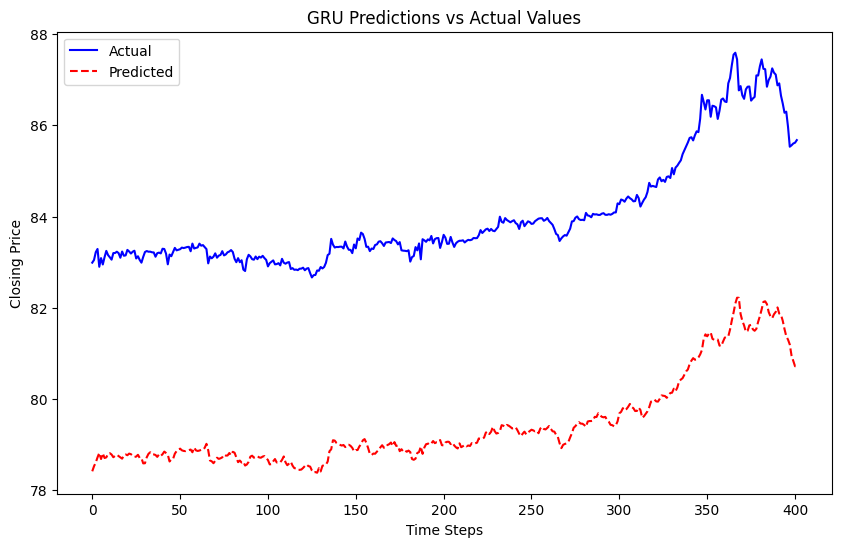

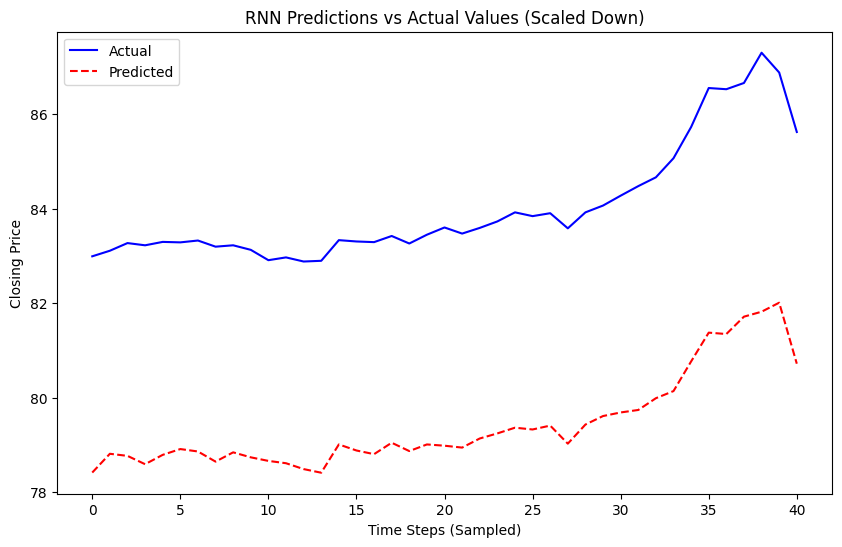

In [8]:
def gru_model(usdInr):
    # Define features (X) and target (y)
    target = 'Closing_price'  # Change to your target column
    features = [col for col in usdInr.columns if col not in ['Date', target]]

    # Separate X and y
    X = usdInr[features]
    y = usdInr[target].values
    X = X.select_dtypes('number').values

    # Normalize X and y
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X = scaler_X.fit_transform(X)
    y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

    # Create sequences
    sequence_length = 30

    def create_sequences(X, y, sequence_length):
        X_seq, y_seq = [], []
        for i in range(len(X) - sequence_length):
            X_seq.append(X[i:i + sequence_length])
            y_seq.append(y[i + sequence_length])
        return np.array(X_seq), np.array(y_seq)

    X_seq, y_seq = create_sequences(X, y, sequence_length)

    # Sequential train-test split (85% train, 15% test)
    split_index = int(len(X_seq) * 0.85)
    X_train, X_test = X_seq[:split_index], X_seq[split_index:]
    y_train, y_test = y_seq[:split_index], y_seq[split_index:]

    # Build GRU model
    gru_model = Sequential([
        GRU(64, activation='relu', input_shape=(sequence_length, X_train.shape[2]), return_sequences=False),
        Dropout(0.2),  # Regularization
        Dense(32, activation='relu'),
        Dense(1)  # Output layer for regression
    ])

    # Compile the model
    gru_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    # Train the model
    gru_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

    # Evaluate the model
    train_loss, train_mae = gru_model.evaluate(X_train, y_train)
    test_loss, test_mae = gru_model.evaluate(X_test, y_test)

    print(f"Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

    # Make predictions
    y_pred_gru = gru_model.predict(X_test)
    y_pred_gru_rescaled = scaler_y.inverse_transform(y_pred_gru.reshape(-1, 1))

    # Rescale actual test data for comparison
    y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1, 1))

    trading_metrics = evaluate_trading_metrics(y_test_rescaled, y_pred_gru_rescaled)
    # Directional Accuracy
    dir_acc = directional_accuracy(y_test_rescaled, y_pred_gru_rescaled)

    mae = mean_absolute_error(y_test_rescaled, y_pred_gru_rescaled)
    mse = mean_squared_error(y_test_rescaled, y_pred_gru_rescaled)
    mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_gru_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_gru_rescaled)

    gru_metrics = pd.DataFrame({
        "Metric": ["MAE", "MSE", "MAPE", "R2", "Directional Accuracy%"],
        "Value": [mae, mse, mape, r2, dir_acc]
    })

    plt.figure(figsize=(10, 6))
    plt.plot(y_test_rescaled, label="Actual", color="blue")
    plt.plot(y_pred_gru_rescaled, label="Predicted", color="red", linestyle="--")
    plt.legend()
    plt.title("GRU Predictions vs Actual Values")
    plt.xlabel("Time Steps")
    plt.ylabel("Closing Price")
    plt.show()

    # Example of selecting a smaller range of data for clarity:
    sampled_indices = range(0, len(y_test_rescaled), 10)  # Down-sample data to every 10th point
    y_test_sampled = [y_test_rescaled[i] for i in sampled_indices]
    y_pred_sampled = [y_pred_gru_rescaled[i] for i in sampled_indices]

    plt.figure(figsize=(10, 6))
    plt.plot(y_test_sampled, label="Actual", color="blue")
    plt.plot(y_pred_sampled, label="Predicted", color="red", linestyle="--")
    plt.legend()
    plt.title("RNN Predictions vs Actual Values (Scaled Down)")
    plt.xlabel("Time Steps (Sampled)")
    plt.ylabel("Closing Price")
    plt.show()

    return gru_metrics, trading_metrics

gru_metrics_df, trading_metrics = gru_model(usdInr)

In [10]:
gru_metrics_df

,Metric,Value
0,MAE,4.575496
1,MSE,21.015120
2,MAPE,0.054429
3,R2,-12.960364
4,Directional Accuracy%,49.625935


In [9]:
trading_metrics

{'Trading Accuracy (%)': 49.62593516209476,
 'ROI (%)': 0.07930000000012569,
 'Sharpe Ratio': 0.016340639860823288,
 'Max Drawdown (%)': 0.3419974007796232}